### MPAS Sensitivity Tests
Andrew Gettelman Nov 2021

Code to read and average fields from model sensitivity tests.

In [1]:
# Import packages
import numpy as np
import xarray as xr
import esmlab
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit, prange

In [2]:
#@njit(parallel=True)  # NOTE: if this is breaking, get rid of the decorator, and change 'prange' to range
def vert_remap(x_mdl, p_mdl, plev):
    """Apply simple 1-d interpolation to a field, x
       given the pressure p and the new pressures plev.
       x_mdl, p_mdl are numpy arrays of shape (nlevel, spacetime).

       NOTE: we try to use Numba here to parallelize the loop.
       If Numba is not available, I tried to 'spoof' the decoratory,
       but I have not tested much. If it breaks, remove the njit decorator,
       and change `prange` to `range' in the `for` statement.
       
       Andrew: changed to do interpolation in log pressure
    """
    out_shape = (plev.shape[0], x_mdl.shape[1])
    output = np.full(out_shape, np.nan)
    for i in prange(out_shape[1]):
        output[:,i] = np.interp(np.log(plev), np.log(p_mdl[:,i]), x_mdl[:,i])
    return output


def pres_from_hybrid(psfc, hya, hyb, p0=100000.):
    """Derive the pressure field on hybrid-sigma levels."""
    # p = a(k)*p0 + b(k)*ps.
    return hya*p0 + hyb*psfc


def lev_to_plev(data, ps, hyam, hybm, P0=100000., new_levels=None):
    """Interpolate data from hybrid-sigma levels to isobaric levels.
    
    data : DataArray with a 'lev' coordinate
    ps   : DataArray of surface pressure (Pa), same time/space shape as data
    hyam, hybm : hybrid coefficients, size of len(lev)
    P0 : reference pressure
    new_levels : the output pressure levels (Pa)
    parallel : if True, use the Numba version to parallelize interpolation step.
    """
    pressure = pres_from_hybrid(ps, hyam, hybm, P0)  # Pa
    if new_levels is None:
        pnew = 100.0 * np.array([1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100, 70, 50, 30, 20, 10, 7, 5, 3, 2, 1])  # mandatory levels, converted to Pa
    else:
        pnew = new_levels
    # reshape data and pressure assuming "lev" is the name of the coordinate
    zdims = [i for i in data.dims if i != 'lev']
    dstack = data.stack(z=zdims)
    pstack = pressure.stack(z=zdims)
    output = vert_remap(dstack.values, pstack.values, pnew)
    output = xr.DataArray(output, dims=("plev", "z"), coords={"plev":pnew, "z":pstack['z']})
    output = output.unstack()
    return output

def pmid_to_plev(data, pmid, new_levels=None):
    """Interpolate data from hybrid-sigma levels to isobaric levels.
    
    data : DataArray with a 'lev' coordinate
    pmid : like data array but the pressure  of each point (Pa)
    new_levels : the output pressure levels (Pa)
    parallel : if True, use the Numba version to parallelize interpolation step.
    """
    pressure = pmid  # Pa
    if new_levels is None:
        pnew = 100.0 * np.array([1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100, 70, 50, 30, 20, 10, 7, 5, 3, 2, 1])  # mandatory levels, converted to Pa
    else:
        pnew = new_levels
    # reshape data and pressure assuming "lev" is the name of the coordinate
    zdims = [i for i in data.dims if i != 'lev']
    dstack = data.stack(z=zdims)
    pstack = pressure.stack(z=zdims)
    output = vert_remap(dstack.values, pstack.values, pnew)
    output = xr.DataArray(output, dims=("plev", "z"), coords={"plev":pnew, "z":pstack['z']})
    output = output.unstack()
    return output

In [3]:
#FV: /glade/scratch/xyhuang/archive/cam-fv-f2000-climo-1deg-l58
#MPAS: /glade/scratch/xyhuang/archive/cam-mpas-f2000-climo-120km-l58
#L32 versions? 


In [4]:
# Paths and Simulations
ipth='/glade/scratch/andrew/archive/'
prefix=''

# Model data

ipth4='/glade/scratch/xyhuang/archive/'


# Now all four runs are on 
ipth='/glade/p/cgd/amp/andrew/mpas/'
#ipth4=ipth

# Note: need to start with an FV run if mixed FV and MPAS...

#cases=['control-f2000-climo','cam6333_mpas_new450','cam-fv-f2000-climo-1deg-l58','cam-mpas-f2000-climo-120km-l58']
cases=['cam6333_fv_mct4','cam6333_mpas_dplin450v2','cam-fv-f2000-climo-1deg-l58','cam-mpas-f2000-climo-120km-l58']
cstxt=['FV L32','MPAS L32','FV L58','MPAS L58']
ctyp=['fv','mpas','fv','mpas']

nr=len(cases)
sep=['/atm/hist/']*nr
ipthall=[ipth,ipth,ipth4,ipth]
sep[3]=sep[3]+'regrid_'
sep[1]=sep[1]+'regrid_'
suff=['','','','']

In [5]:
sep

['/atm/hist/', '/atm/hist/regrid_', '/atm/hist/', '/atm/hist/regrid_']

In [10]:
#Variable Names

varn=['TGCLDLWP','TGCLDIWP','CLDTOT'  ,'PRECL'  ,'AODVIS' ,'CDNUMC'       ,'SWCF','LWCF','FSNT','FSNS','FSNTC','TS','LANDFRAC','TREFHT']
varu=['kg/m2'   ,'kg/m2'   ,'Fraction','mm/d'   ,'Unitless','#/cm3 [10km]','W/m2','W/m2','W/m2','W/m2','Wm-2' ,'K','Fraction','K']
vscl=[1.        ,1.        ,1         ,86400000.,1.        ,1.e-10        ,1.     ,1, 1, 1,1,1,1,1]
varf=[''        ,''        ,''      ,''   ,''  ,'','','','','','','','','']
vartx=['Liquid Water Path (LWP)'    ,'Ice Water Path (IWP)',    'Cloud Fraction','Total Precipitation',
       'Aerosol Optical Depth', 'Column Drop Number', 'SW CRE','LW CRE','RESTOM','RESSURF','Clr Sky SW','Surface Temperature','Land Fraction','2m Temperature']

varnout=varn.copy()
varnout[8]='RESTOM'
varnout[9]='RESSURF'

#CERES lwp could be cldwatrad_total_daily or lwp_total_daily
varcdy=['lwp_total_daily','iwp_total_daily', 'cldarea_total_daily','','',
        'toa_sw_all_daily','cldtau_total_daily','toa_sw_clr_daily','toa_lw_clr_daily']   

nv=len(varn)

In [11]:
#Make big arrays to hold regional averages
coordinates={'runs':cstxt,'variables':varn}
#Regional or global
mavg= xr.DataArray(np.zeros((nr,nv)),dims=('runs','variables'),coords=coordinates)

#Make big arrays to hold zonal averages 
tmpin = ipth+prefix+cases[0]+sep[0]+cases[0]+'.cam.h0.0001-01.nc'
print(tmpin)
t1=xr.open_dataset(tmpin)
coords2={'runs':cstxt,'variables':varnout,'lat':t1.lat}
coords3={'runs':cstxt,'variables':varnout,'lat':t1.lat,'lon':t1.lon}
ny=len(t1.lat)
nx=len(t1.lon)
#Annual Zonal mean
azm = xr.DataArray(np.zeros((nr,nv,ny)),dims=('runs','variables','lat'),coords=coords2)
astd = xr.DataArray(np.zeros((nr,nv,ny)),dims=('runs','variables','lat'),coords=coords2)

#Annual Mean
amb = xr.DataArray(np.zeros((nr,nv,ny,nx)),dims=('runs','variables','lat','lon'),coords=coords3)

/glade/p/cgd/amp/andrew/mpas/cam6333_fv_mct4/atm/hist/cam6333_fv_mct4.cam.h0.0001-01.nc


In [12]:
subset=['*.h0.000[1-5]*']*nr #Subset 
#sep=['/atm/hist/']*nr
#subset='*.h0.*' # All time
#subset[1]='*.h0.000[1-5]*.regrid.nc'

In [13]:
#Monthly Loop
#Loop for cases

Lv = 2.501e6
Lf = 3.337e5

for r in range(nr):
    minfiles = ipthall[r]+prefix+cases[r]+sep[r]+subset[r]+suff[r]
    print(cases[r])
    ms1 = xr.open_mfdataset(minfiles,combine='by_coords')
#loop for variables
    for v in range(nv):
#average over region Selected region (lat and lon)
        if (len(varf[v]) > 0):
#zonal mean...
            af=ms1[varf[v]].mean(dim=['time'])
            am=ms1[varn[v]].mean(dim=['time'])/af
            del am,af  #,var,varv,freq
        else:
#            var=ms1[varn[v]].sel(lon=slice(xlon[0],xlon[1]),lat=slice(ylat[0],ylat[1]))
            am=ms1[varn[v]].mean(dim=['time'])
            #vertical average
            if (varn[v]=='PRECL'):
                var=ms1[varn[v]]+ms1['PRECC']
                am=var.mean(dim=('time'))
                del var
            if (varn[v]=='FSNT'):
                var=ms1[varn[v]]-ms1['FLNT']
                am=var.mean(dim=('time'))
                del var
            if (varn[v]=='FSNS'):
#                lhflx=Lv*ms1['QFLX']
                lhflx=(Lv+Lf)*ms1['QFLX']-Lf*1.e3*(ms1['PRECC']+ms1['PRECL']-ms1['PRECSC']-ms1['PRECSL'])
                var=ms1[varn[v]]-ms1['FLNS']-ms1['SHFLX']-lhflx
                am=var.mean(dim=('time'))
                del lhflx,var
            if (varn[v]=='TOT_CLD_VISTAU'):
                var=ms1[varn[v]].sum(dim=('lev'))
                am=var.mean(dim=('time'))
                del var
            if (varn[v]=='FREQR'):
                am=ms1[varn[v]].mean(dim=['lev','time'])
            if(varn[v]=='T'):
                var=var.sel(lev=850.,method="nearest")
                am=var.mean(dim=('time'))
                del var
#        print(varn[v])
#        mavg[r,v]=var.mean()

#Regrid here if mpas to fv lat/lon....
        if ctyp[r]=='mpas':
            tmp=am.copy()
            del am
            am=tmp.interp(lat=amb.lat, lon=amb.lon)

        azm[r,v,:]=am.mean(dim=['lon'])
        amb[r,v,:,:]=am
        del am 
        
        
#NOTE: to add standard deviations, will want to rebuild this loop...

cam6333_fv_mct4
cam6333_mpas_dplin450v2
cam-fv-f2000-climo-1deg-l58
cam-mpas-f2000-climo-120km-l58


In [14]:
minfiles

'/glade/p/cgd/amp/andrew/mpas/cam-mpas-f2000-climo-120km-l58/atm/hist/regrid_*.h0.000[1-5]*'

Read CERES Data (from zonal mean files)

In [15]:
cpth='/glade/work/andrew/ceres/'
cfile='CERES_EBAF_Ed4.1_Subset_200101-201812.nc'
cfile2='CERES_SYN1deg-Month_Terra-Aqua-MODIS_Ed4.1_Subset_200101-201812.nc'

cdat = xr.open_mfdataset(cpth+cfile,combine='by_coords')
cdat2 = xr.open_mfdataset(cpth+cfile2,combine='by_coords')

#Pull out variables
#ctau=cdat['cldtau_total_day_mon']

#Pull variables and Average over time
cswcfzm=cdat['ztoa_cre_sw_mon'].mean(dim=['time'])

#Standard deviation of monthly anomalies....
climo = cdat['ztoa_cre_sw_mon'].groupby("time.month").mean("time")
anom = cdat['ztoa_cre_sw_mon'].groupby("time.month") - climo
cswcfstd=anom.std(dim=['time'])
del climo,anom

clwcfzm=cdat['ztoa_cre_lw_mon'].mean(dim=['time'])

#Standard deviation of monthly anomalies....
climo = cdat['ztoa_cre_lw_mon'].groupby("time.month").mean("time")
anom = cdat['ztoa_cre_lw_mon'].groupby("time.month") - climo
clwcfstd=anom.std(dim=['time'])
del climo,anom

cctotzm=cdat['zcldarea_total_daynight_mon'].mean(dim=['time'])

#Standard deviation of monthly anomalies....
climo = cdat['zcldarea_total_daynight_mon'].groupby("time.month").mean("time")
anom = cdat['zcldarea_total_daynight_mon'].groupby("time.month") - climo
cctotstd=anom.std(dim=['time'])
del climo,anom

ctauzm=cdat['zcldtau_total_day_mon'].mean(dim=['time'])

climo = cdat['zcldtau_total_day_mon'].groupby("time.month").mean("time")
anom = cdat['zcldtau_total_day_mon'].groupby("time.month") - climo
ctaustd=anom.std(dim=['time'])
del climo,anom

cfsntzm=cdat['ztoa_sw_all_mon'].mean(dim=['time'])

cfsntczm=cdat['ztoa_sw_clr_c_mon'].mean(dim=['time'])


/glade/work/andrew/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/glade/work/andrew/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/glade/work/andrew/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/glade/work/andrew/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]


In [16]:

#cswcfavg.values

cctauzm=cdat2['zcldtau_lin_total_mon'].mean(dim=['time'])

#Standard deviation of monthly anomalies....
climo = cdat2['zcldtau_lin_total_mon'].groupby("time.month").mean("time")
anom = cdat2['zcldtau_lin_total_mon'].groupby("time.month") - climo
cctaustd=anom.std(dim=['time'])
del climo,anom

cclwpzm=cdat2['zlwp_total_mon'].mean(dim=['time'])/1000.

#Standard deviation of monthly anomalies....
climo = cdat2['zlwp_total_mon'].groupby("time.month").mean("time")
anom = cdat2['zlwp_total_mon'].groupby("time.month") - climo
cclwpstd=anom.std(dim=['time'])/1000.
del climo,anom

cciwpzm=cdat2['ziwp_total_mon'].mean(dim=['time'])/1000.



/glade/work/andrew/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/glade/work/andrew/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]


In [17]:
#cdat2
#Pull variables and Average over region
#cswcfzm=cdat2['ztoa_sw_clr_mon'].mean(dim=['time'])-cdat2['ztoa_sw_all_mon'].mean(dim=['time'])
#clwcfzm=cdat2['ztoa_lw_clr_mon'].mean(dim=['time'])-cdat2['ztoa_lw_all_mon'].mean(dim=['time'])

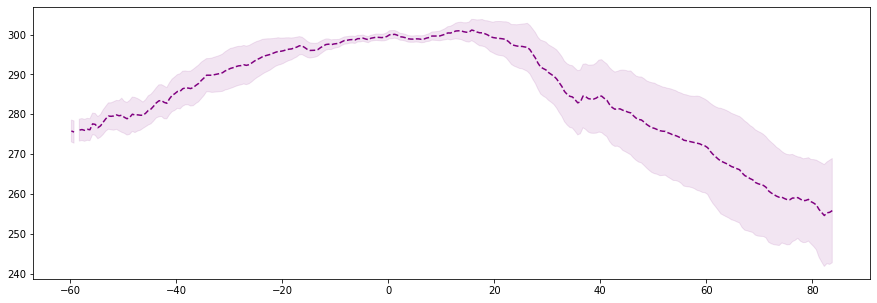

In [18]:
#Read CPC Temperature Data
tsf='/glade/work/xyhuang/obs/cpc/cpc.air.mon.mean.nc'
ts=xr.open_dataset(tsf)
tsmean=ts.sel(time=slice("1990-01-01","2010-12-31")).mean(dim='time')

tsann=ts.sel(time=slice("1990-01-01","2010-12-31")).groupby("time.year").mean(dim='time')
azmtsstd=tsann.mean(dim='lon').std(dim='year')

mzmtsstd=ts.mean(dim='lon').std(dim='time')

#tsmean.air.plot()
tszm=tsmean.mean(dim='lon')

plt.rcParams['figure.figsize'] = [15, 5]

plt.plot(tszm.lat,tszm.air,label='CPC Obs',color='purple',linestyle='--')
plt.fill_between(tszm.lat,tszm.air+mzmtsstd.air,tszm.air-mzmtsstd.air,alpha=0.1,color='purple')

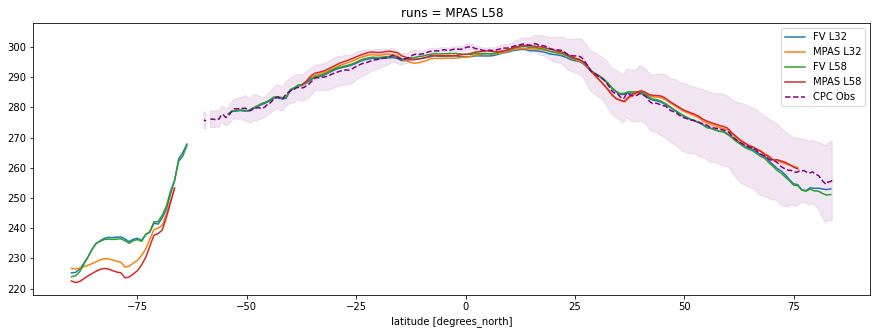

In [21]:
#Mask temperature data for land points.

vartx[13]='Land 2m Temperature'

tsmask=amb.sel(variables='TREFHT').where(amb.sel(variables='LANDFRAC') > 0.9)
zmtslnd=tsmask.mean(dim='lon')




for r in range(nr):
    zmtslnd.isel(runs=r).plot(label=cstxt[r])

plt.plot(tszm.lat,tszm.air,label='CPC Obs',color='purple',linestyle='--')
plt.fill_between(tszm.lat,tszm.air+mzmtsstd.air,tszm.air-mzmtsstd.air,alpha=0.1,color='purple')   
#tszm.air.plot(label='CPC Obs')
plt.legend()


In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
plt.rcParams['figure.figsize'] = [15, 15]
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn as sns

In [23]:
varn[11]

'TS'

/glade/work/andrew/miniconda3/envs/analysis2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


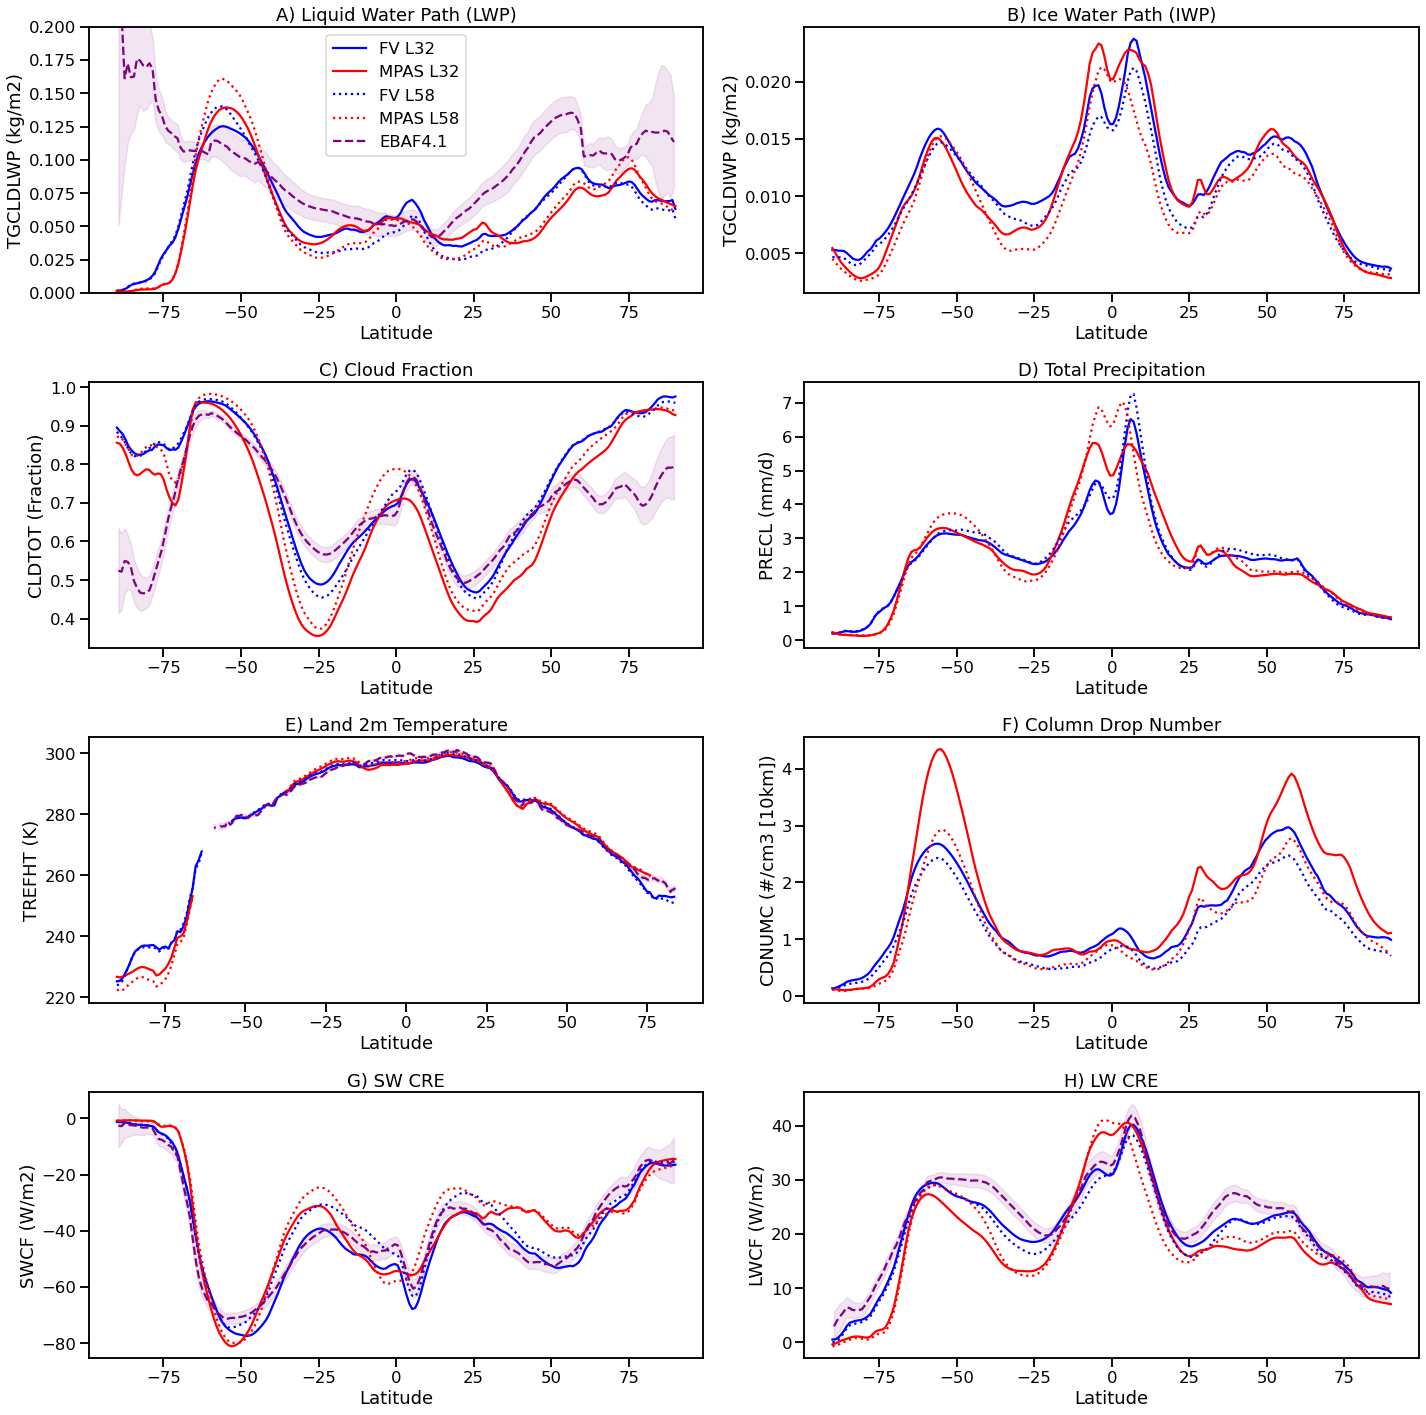

In [26]:
savfig=True

#Fancier plots
plt.rcParams['figure.figsize'] = [15, 20]

#linestyles = ['-', '-','-','-', ':', ':',':', ':','-']
#cls=['black','blue','red','green','black','blue','red','green','orange','maroon','coral','indigo','brown','gray']

hfont = {'fontname':'Helvetica'}

lbl=['A','B','C','D','E','F','G','H','I','J']


linestyles = ['-', '-',':',':']
cls=['blue','red','blue','red']


#fig,axs=plt.subplots(nv)

# Set variables to plot from list

vv=[0,1,2,3,13,5,6,7]
nvp=len(vv)

ncol=2
nrow=int(nvp/ncol)

fig,axs=plt.subplots(nrow,2,figsize=(20, nrow*5))

axs = axs.ravel()

for vi in range(nvp):
    
    v=vv[vi]
    
    sns.set_context("talk")

    if varn[v] == 'TREFHT':

        for r in range(nr):
            axs[vi].plot(zmtslnd.lat,zmtslnd.sel(runs=cstxt[r]),linestyles[r],label=cstxt[r],color=cls[r])
        axs[vi].plot(tszm.lat,tszm.air,label='CPC Obs',color='purple',linestyle='--')
        axs[vi].fill_between(tszm.lat,tszm.air+azmtsstd.air,tszm.air-azmtsstd.air,alpha=0.1,color='purple')   
    
    else:
    
        for r in range(nr):        
            axs[v].plot(azm.lat,azm.sel(runs=cstxt[r],variables=varnout[v])*vscl[v],linestyles[r],label=cstxt[r],color=cls[r])

        if varn[v] == 'SWCF' or varn[v] == 'LWCF' or varn[v] == 'CLDTOT' or varn[v] == 'FSUTOA' or varn[v]=='TGCLDLWP' or varn[v]=='TOT_CLD_VISTAU':
            if varn[v] == 'SWCF':
                tmp=cswcfzm.values
                std=cswcfstd.values
            if varn[v] == 'LWCF':
                tmp=clwcfzm.values
                std=clwcfstd.values
            if varn[v] == 'CLDTOT':
                tmp=cctotzm.values/100.
                std=cctotstd.values/100.
            if varn[v] =='FSUTOA':
                tmp=cfsntzm
            if varn[v] =='FSNTC':
                tmp=cfsntczm
            if varn[v] =='TOT_CLD_VISTAU':
                tmp=cctauzm
                std=cctaustd.values
            if varn[v] =='TGCLDLWP':
                tmp=cclwpzm
                std=cclwpstd.values
                axs[v].set_ylim([0,0.2])
            axs[vi].plot(cswcfzm.lat,tmp,linestyles[0], label='EBAF4.1',color='purple',linestyle='--')
            axs[vi].fill_between(cswcfzm.lat,tmp+std,tmp-std,alpha=0.1,color='purple')

#    axs[v].set_title(lbl[v]+') '+vartx[v],fontsize=16,**hfont)
    axs[vi].set_title(lbl[vi]+') '+vartx[v])
#    if varn[v] =='TGCLDLWP' or varn[v] =='TGCLDIWP':
    if varn[v] =='TGCLDLWP':
        axs[vi].legend(loc='upper center')#,fontsize='small')
#    else:
#        axs[v].legend(loc='lower right',fontsize='small')            
    axs[vi].set_xlabel('Latitude')
    axs[vi].set_ylabel(varn[v]+' ('+varu[v]+')')

    
fig.tight_layout()
#plt.show()
if savfig: 
    plt.savefig('zm_mpas_diff_L58L32_8pnlT2Mann.pdf')

### Zonal mean
Will need a different zonal mean read/averager....(Have this code in ML stuff I think). 

### Read ERAI Climatology

In [21]:
#Read in ERAI Data
seas='ANN'

epth='/glade/work/andrew/erai/'
fn=epth+'ERAI_'+seas+'_climo.nc'
eradat=xr.open_dataset(fn).squeeze()

#ERA zonal mean...
erazm=eradat.mean(dim=['lon'])

In [43]:
#eradat
levpa=np.array(100.*erazm.lev)
levpa

array([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,
        82500.,  80000.,  77500.,  75000.,  70000.,  65000.,  60000.,
        55000.,  50000.,  45000.,  40000.,  35000.,  30000.,  25000.,
        22500.,  20000.,  17500.,  15000.,  12500.,  10000.,   7000.,
         5000.,   3000.,   2000.,   1000.,    700.,    500.,    300.,
          200.,    100.], dtype=float32)

### Test interpolation
Use PMID variable in mpas to go to standard pressure levels
Will also want to use code to convert to CAM hybrid levels (get code from Cecile....). 

In [120]:
##Read MPAS file
r=3
varn1='U'
vscl1=1.
minfiles = ipthall[r]+prefix+cases[r]+sep[r]+subset[r]+suff[r]
print(cases[r])
d1 = xr.open_mfdataset(minfiles,combine='by_coords',data_vars=[varn1])

cam-mpas-f2000-climo-120km-l58


In [121]:
## Test Interpolation for MPAS to ERA....
if ctyp[r]=='mpas':
    out=pmid_to_plev(d1[varn1], d1.PMID, new_levels=levpa)
else:
    out=lev_to_plev(d1[varn1], d1.PS, d1.hyam, d1.hybm, P0=100000., new_levels=levpa)

In [129]:
#Works!
#zm=out.mean(dim=['time','lon'])
#zm.plot()

### Read Simulation Data and Set up big arrays

In [137]:
#Select variable

#del fiall, afiall, azmfiall

varn1='U'
vscl1=1.

In [138]:
for r in range(nr):

    #Read Model Data for needed fields....(extract variable first)

#    fn=fspec[r]+'cc_'+cases[r]+fsuff
#    d1= xr.open_dataset(fn)
    minfiles = ipthall[r]+prefix+cases[r]+sep[r]+subset[r]+suff[r]
    print(cases[r])
    d1 = xr.open_mfdataset(minfiles,combine='by_coords',data_vars=[varn1])

#Interpolate to ERAI vertical levels
    if ctyp[r]=='mpas':
        fi=pmid_to_plev(d1[varn1], d1.PMID, new_levels=levpa)
#Horiz interp if mpas
        tmp=fi.copy()
        del fi
        fi=tmp.interp(lat=fiall.lat, lon=fiall.lon)
    else:
        fi=lev_to_plev(d1[varn1], d1.PS, d1.hyam, d1.hybm, P0=100000., new_levels=levpa)

#rename dimension as lev....
    fi=fi.rename({'plev':'lev'})
        
    if r==0:
        coordinates={'runs':cstxt,'lon':fi.lon,'lat':fi.lat,'lev':fi.lev,'time':fi.time}
        ny=len(fi.lat)
        nx=len(fi.lon)
        nz=len(fi.lev)
        nt=len(fi.time)
        fiall = xr.DataArray(np.zeros((nr,nz,nt,ny,nx)),dims=('runs','lev','time','lat','lon'),coords=coordinates)

    
    
    fiall[r,:,:,:,:]=fi[:,:,:,:].interp(lev=fiall.lev,method="linear") #swaps dims?

# put back levels to hPa
fiall['lev']=levpa/100.


cam6333_fv_mct4
cam6333_mpas_dplin450v2
cam-fv-f2000-climo-1deg-l58
cam-mpas-f2000-climo-120km-l58


In [139]:
#Test plot raw
#zmfi=fi.mean(dim=['time','lon'])
#plt.rcParams['figure.figsize'] = [40, 12]
#zmfi.plot()
#plt.title('mpas5 raw')
#plt.ylim([1000.,5.])
#lt.yscale('log')

In [140]:
#Seasonal, annual and zonal mean climo
#sfiall = fiall.groupby('time.season').mean('time')*scl
#szfiall = sfiall.mean(dim=['lon'])
#vscl1=0.01
afiall = fiall.mean(dim=['time'])*vscl1
azmfiall = afiall.mean(dim=['lon'])

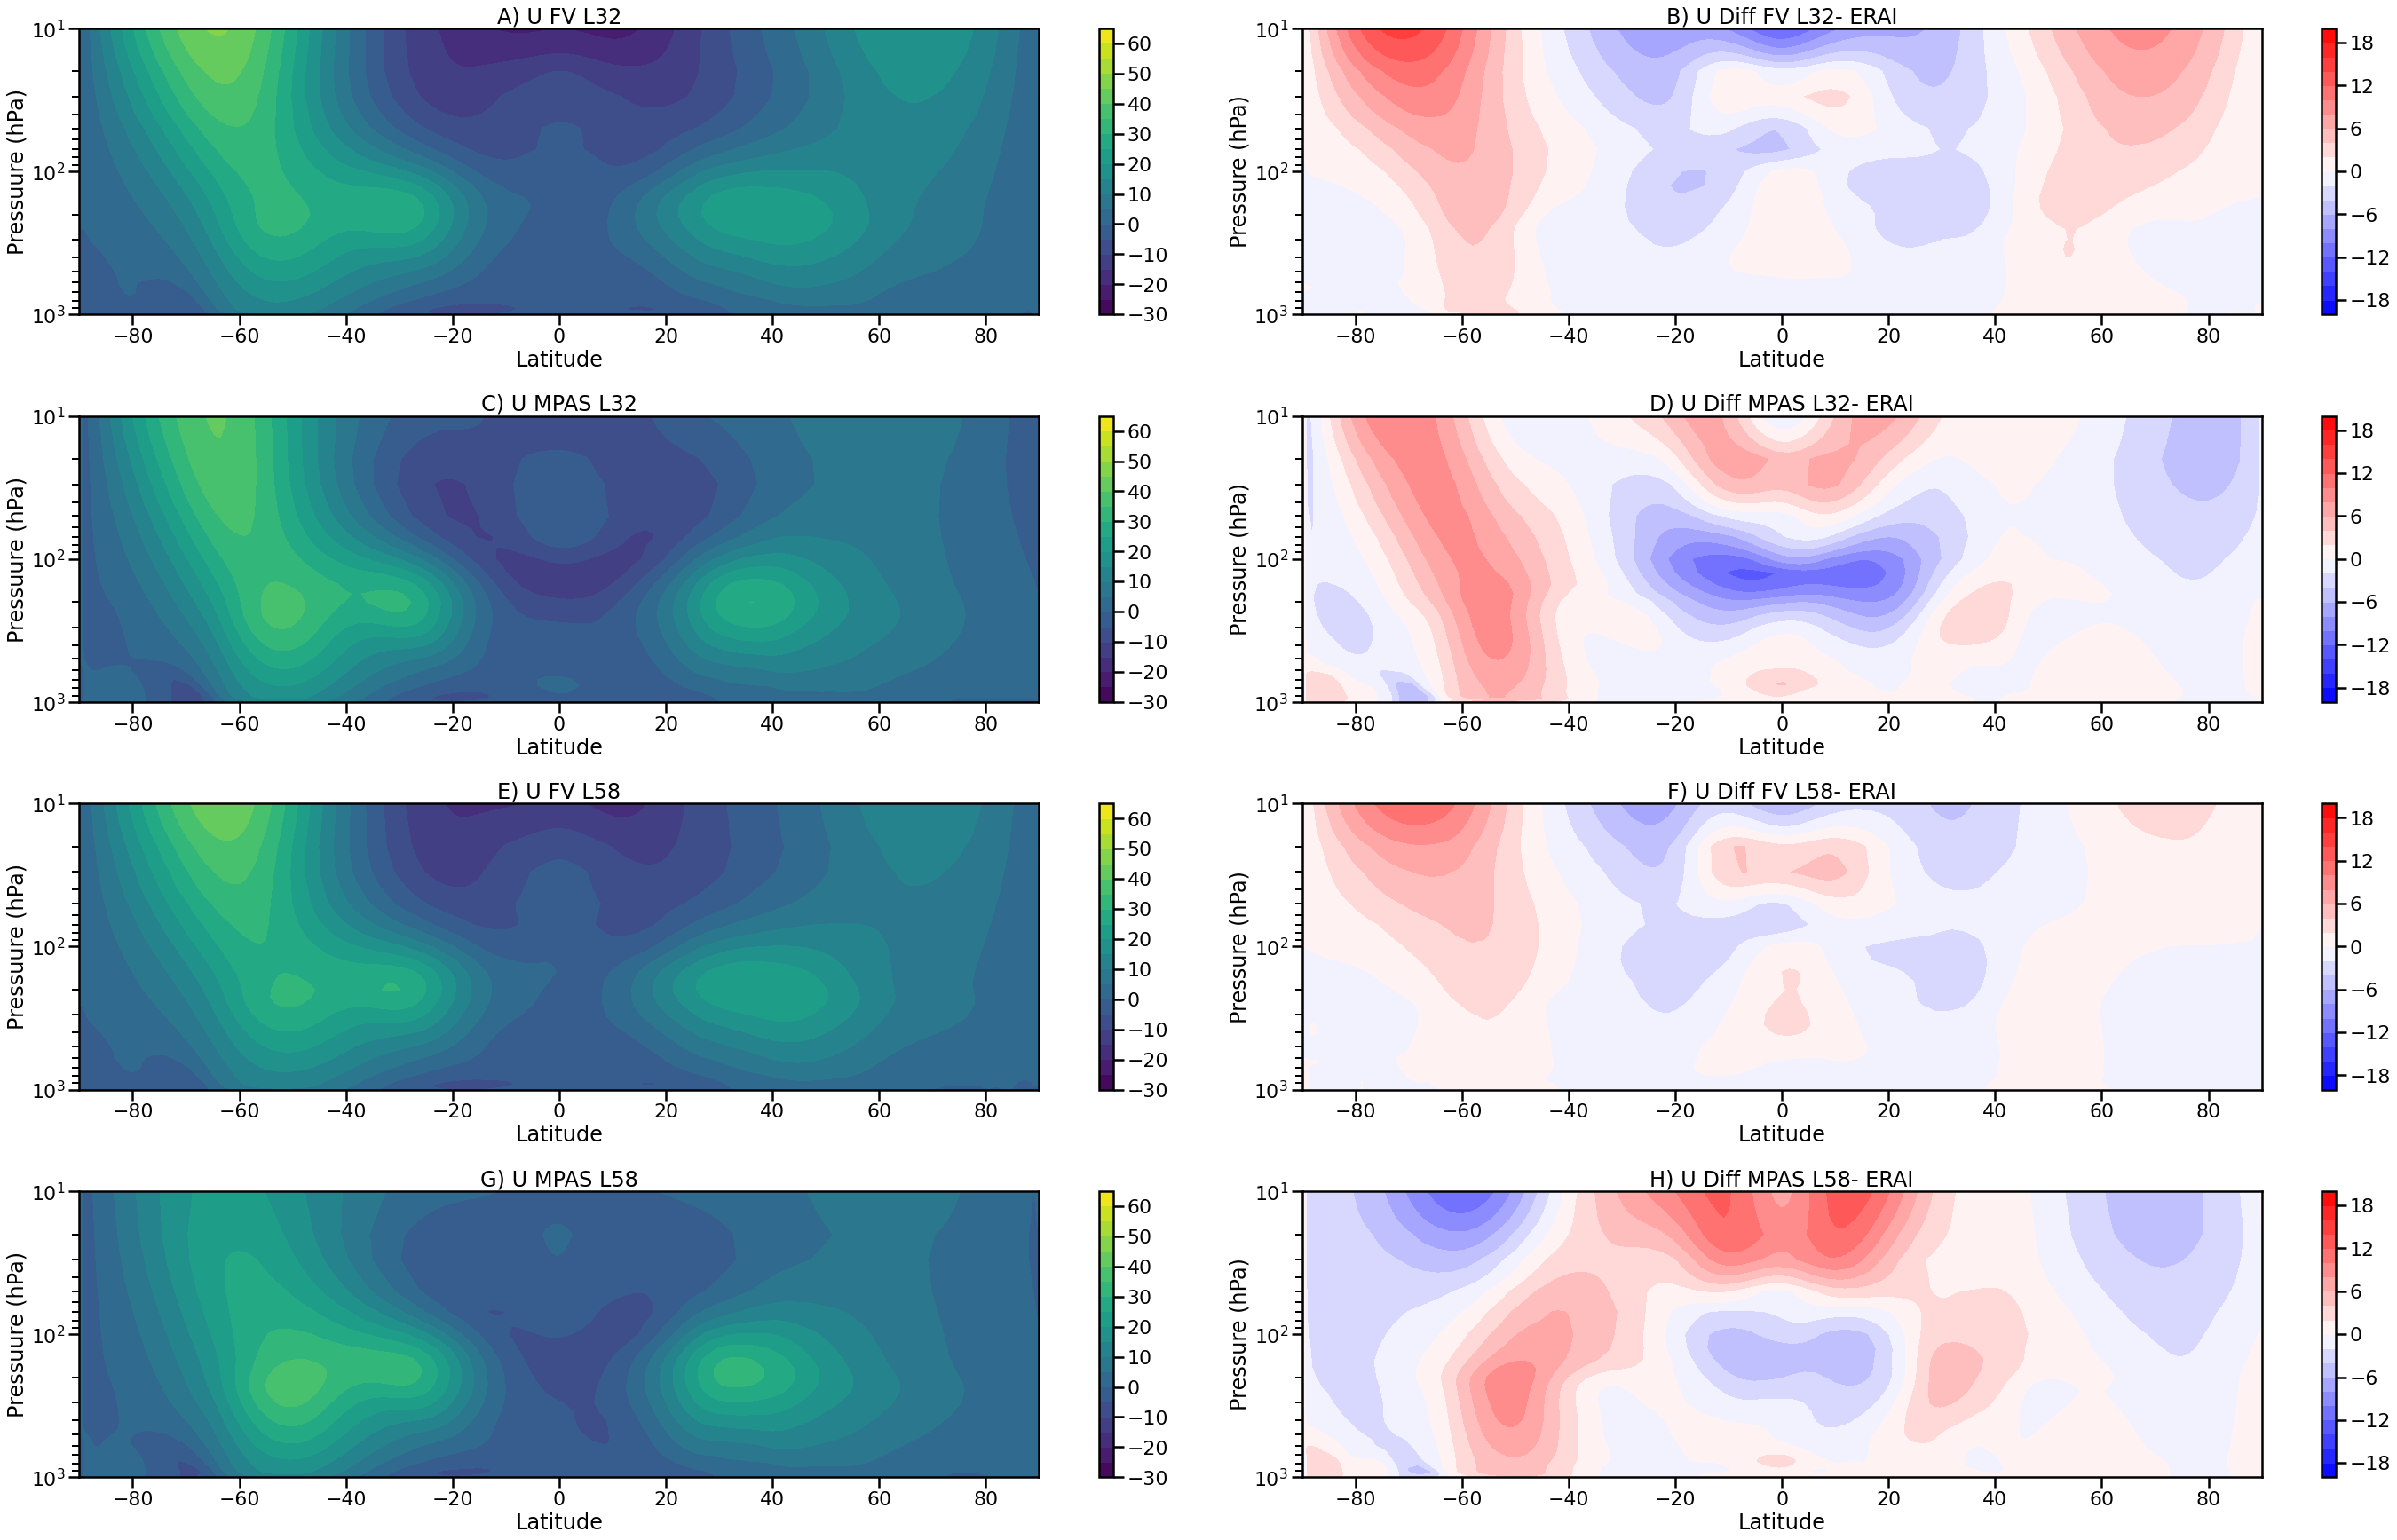

In [141]:
savfig=True

#annual all runs...
sns.set_context("poster")
plt.rcParams['figure.figsize'] = [40, 12*nr]
#plt.rcParams['figure.dpi'] = 200
f2=plt.figure(0)

scl=50.
off=0.
evar=varn1
dscl=0.1
doff=-1.

ERAdiff= True

if varn1=='U':
    scl=5.
    off=-30.
    evar='U'
    dscl=2.
    doff=-20.
elif varn1=='T':
    scl=6.
    off=190.
    dscl=1.5
    doff=-15.
    evar='T'
elif varn1=='Q':
    scl=0.1
    off=0.
    dscl=0.1
    doff=-1.
    evar='SHUM'
elif varn1=='CLOUD':
    scl=0.05
    off=0.
    dscl=0.03
    doff=-0.3
lvs=np.arange(20)*scl+off
dlvs=np.arange(21)*dscl+doff

erainterp=erazm[evar].interp_like(azmfiall)

c=0

for s in range(nr):
    ax=plt.subplot(nr*2,2,2*s+1)
    plt.tight_layout()
    plt.contourf(azmfiall.lat,azmfiall.lev,azmfiall.isel(runs=s),levels=lvs)
    plt.title(lbl[c]+') '+varn1+' '+cstxt[s])
    plt.xlabel('Latitude')
    plt.ylabel('Pressuure (hPa)')
    cbar=plt.colorbar()
    ax.set_ylim([1000.,10.])
    ax.set_yscale('log')

    c=c+1
#Difference from Reference (would need to reinterpolate to ERAI...)

    ax=plt.subplot(nr*2,2,2*s+2)
    plt.tight_layout()
#    if varn1 == 'CLOUD':

    if ERAdiff:
        diff=azmfiall.isel(runs=s)-erainterp
        dtxt='ERAI'
    else:
        diff=azmfiall.isel(runs=s)-azmfiall.isel(runs=0)
        dtxt=cstxt[0]    
    plt.contourf(azmfiall.lat,erainterp.lev,diff,cmap='bwr',levels=dlvs)
    plt.title(lbl[c]+') '+varn1+' Diff '+cstxt[s]+ '- '+dtxt)
    plt.xlabel('Latitude')
    plt.ylabel('Pressure (hPa)')
    cbar=plt.colorbar()
    ax.set_ylim([1000.,10.])
    ax.set_yscale('log')
    
    c=c+1
    
if savfig: 
    plt.savefig('zm_'+varn1+'_cam633_mpas-vert.pdf')

In [136]:
#diff

<Figure size 864x576 with 0 Axes>

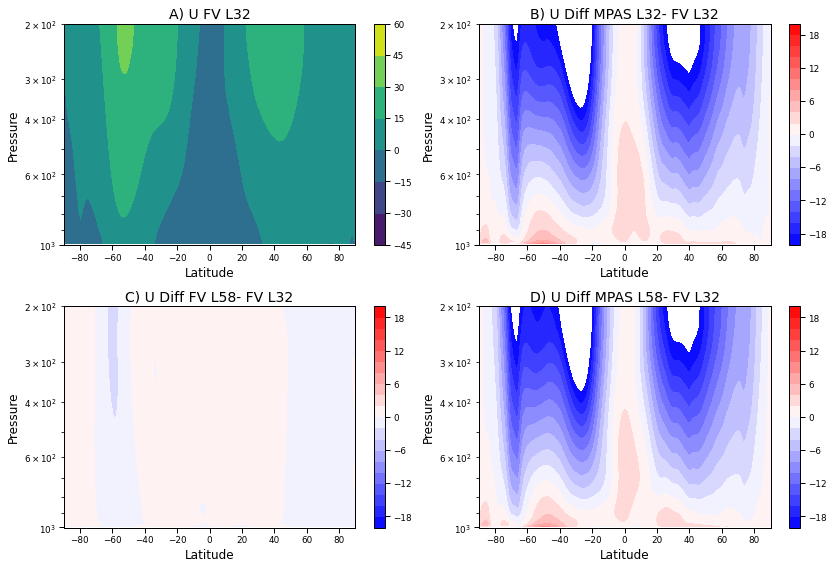

In [27]:
#Zonal mean Difference from control
sns.set_context("paper")
plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams['figure.dpi'] = 200
plt.tight_layout()
f2=plt.figure(0)
#varn='AQSNOW'
if varn1=='U':
    dscl=2.
    doff=-20.
elif varn1=='T':
    dscl=2.
    doff=-20.
elif varn1=='CLOUD' or varn1=='FICE':
    dscl=0.05
    doff=-0.5
elif varn1=='AQRAIN':
    dscl=0.15
    doff=-1.5
elif varn1=='AQSNOW':
    dscl=0.3
    doff=-3. 

# Plot control
ax=plt.subplot(2,2,1)
plt.contourf(azmfiall.lat,azmfiall.lev,azmfiall.isel(runs=0))
plt.title(lbl[0]+') '+varn1+' '+cstxt[0],size=14.)
plt.xlabel('Latitude',size=12.)
plt.ylabel('Pressure',size=12.)
cbar=plt.colorbar()
ax.set_ylim([1000.,200.])
ax.set_yscale('log') 
             
simsel=[0,1,2,3]    
lvs=np.arange(21)*dscl+doff
for s in range(3):
    ax=plt.subplot(2,2,s+2)
    plt.tight_layout()
    diff=azmfiall.isel(runs=simsel[s+1])-azmfiall.isel(runs=0)
    plt.contourf(azmfiall.lat,azmfiall.lev,diff,cmap='bwr',levels=lvs)
    plt.title(lbl[s+1]+') '+varn1+' Diff '+cstxt[simsel[s+1]]+ '- '+cstxt[0],size=14.)
    plt.xlabel('Latitude',size=12.)
    plt.ylabel('Pressure',size=12.)
    cbar=plt.colorbar()
#    cbar.set_label('Frequency')
    ax.set_ylim([1000.,200.])
    ax.set_yscale('log')
#fn='pumas_implicit5_zm_'+varn1+'_diff.png'
#plt.savefig(fn)

In [49]:
# RESTOM (8), RESSURF (9) (Global annual means)
#azm
idxtop=8
idxbot=9

In [52]:
#Calculate Weights
plt.rcParams['figure.figsize'] = [12, 8]
wgty=np.cos(azm.lat * np.pi/180.)
wgty=wgty/wgty.sum()
#wgty.plot()
#wgty.sum()

In [53]:
#Calculate global mean
#Ship - No Ship present
gam1=esmlab.statistics.weighted_mean(azm,dim=['lat'],weights=wgty)
#gam2=esmlab.statistics.weighted_mean(zmts2,dim=['lat'],weights=wgty)
#gmdiff=(gam2-gam1)*scl
#gmdiff.values

In [54]:
# Global mean RESTOM
gam1.sel(variables='RESTOM')

<xarray.DataArray (runs: 2)>
array([1.85572753, 2.07191526])
Coordinates:
  * runs       (runs) <U12 'MPAS Orig' 'MPAS DPlinV2'
    variables  <U8 'RESTOM'

In [55]:
# Global mean RESTOM - RESSURF
gam1.sel(variables='RESTOM')-gam1.sel(variables='RESSURF')

<xarray.DataArray (runs: 2)>
array([0.0862543 , 0.06557606])
Coordinates:
  * runs     (runs) <U12 'MPAS Orig' 'MPAS DPlinV2'

In [ ]:
for r in range(nr):
    runstr=np.array_str(gam1.runs[r].values).ljust(11)
    rstr=" {:.1f}".format(gam1[r].sel(variables='RESTOM').values)
    print(runstr,rstr)

In [ ]:
for v in range(nv):
        gam1[:,v]=gam1[:,v]*vscl[v]

In [ ]:
import pandas as pd
from IPython.display import display

dfg = pd.DataFrame(gam1.values, columns = gam1.variables, index=gam1.runs)

print(dfg)



In [ ]:
## Table of values....

pd.set_option('precision', 3)
display(dfg)

### Recalculate RESTOM and RESSURF from MPAS run without regridding....

In [ ]:
#Read files....
sep=['/atm/hist/']*nr
r=0
minfiles = ipthall[r]+prefix+cases[r]+sep[r]+subset[r]
print(cases[r])
ms1 = xr.open_mfdataset(minfiles,combine='by_coords')

r=1
minfiles = ipthall[r]+prefix+cases[r]+sep[r]+subset[r]
print(cases[r])
ms3 = xr.open_mfdataset(minfiles,combine='by_coords')

#Weights
wgt1=np.cos(ms1.lat * np.pi/180.)
wgt1=wgt1/wgt1.sum()
#wgty.plot()
wgt1.sum()

wgt3=np.cos(ms3.lat * np.pi/180.)
wgt3=wgt3/wgt3.sum()
#wgty.plot()
wgt3.sum()

cam6333_mpas_new450


In [ ]:
# Calculate RESSURF and RESTOM: add to array then take mean.

lhflx=(Lv+Lf)*ms1['QFLX']-Lf*1.e3*(ms1['PRECC']+ms1['PRECL']-ms1['PRECSC']-ms1['PRECSL'])
var=ms1['FSNS']-ms1['FLNS']-ms1['SHFLX']-lhflx
ms1['RESSURF']=var

ms1['RESTOM']=ms1['FSNT']-ms1['FLNT']

am1=ms1.mean(dim=['time','lon'])

del lhflx,var
lhflx=(Lv+Lf)*ms3['QFLX']-Lf*1.e3*(ms3['PRECC']+ms3['PRECL']-ms3['PRECSC']-ms3['PRECSL'])
var=ms3['FSNS']-ms3['FLNS']-ms3['SHFLX']-lhflx
ms3['RESSURF']=var

ms3['RESTOM']=ms3['FSNT']-ms3['FLNT']
am3=ms3.mean(dim=['time','lon'])


In [ ]:

gam1SURF=esmlab.statistics.weighted_mean(am1['RESSURF'],dim=['lat'],weights=wgt1)
gam1TOM=esmlab.statistics.weighted_mean(am1['RESTOM'],dim=['lat'],weights=wgt1)

gam3SURF=esmlab.statistics.weighted_mean(am3['RESSURF'],dim=['lat'],weights=wgt3)
gam3TOM=esmlab.statistics.weighted_mean(am3['RESTOM'],dim=['lat'],weights=wgt3)

print(cstxt[1],gam1SURF.values,gam1TOM.values)
print(cstxt[3],gam3SURF.values,gam3TOM.values)

### FORCING Calculations below : Maps of differences

In [ ]:
amb.runs

In [ ]:
var='SWCF'
rnm='Control'
aod=amb.sel(variables=var)
diff=aod.sel(runs=rnm)-aod.sel(runs=rnm+'-PI')

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude=180.))
diff.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                                levels=30, cmap='RdBu_r')
ttx=var+' '+rnm+' PD-PI'
ax.set_title(ttx)
ax.gridlines()

ax.add_feature(cartopy.feature.COASTLINE)

In [ ]:
AM=amb.to_dataset(dim='variables')

In [ ]:
lbl=['A','B','C','D','E','F','G','H','J','K','L','M']


var=['SWCF','LWCF','RESTOM','TGCLDLWP']
vrng=np.array([[-10,10.],[-10,10.],[-10,10.],[-50,50.]])
varscl=[1.        ,1.        ,1   ,1.e3]

rnm=['Control','PUMAS Update','PUMAS Implicit Fall','PUMAS Accre']

sns.set_context("talk")

alpha=0.1

nc=4
nv=len(var)

n_plots = nc*nv

n_cols = nc
n_rows = nv

fig=plt.figure(figsize=(n_cols*12, n_rows*5))

    # Also manually adjust the spacings which are used when creating subplots
fig.subplots_adjust(hspace=0.25, wspace=0.05, top=0.95, bottom=0.05,
                    left=0.075, right=0.925)

cnt=0
for v in range(nv):
    tmp=AM[var[v]]*varscl[v]
    for c in range(nc):
        diff=tmp.sel(runs=rnm[c])-tmp.sel(runs=rnm[c]+'-PI')
        ax = plt.subplot(n_rows, n_cols, cnt+1, projection=ccrs.PlateCarree())
        diff.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=vrng[v,0], vmax=vrng[v,1])    

        ax.coastlines()
        ax.set_title(lbl[c]+') '+var[v]+' '+rnm[c]+' PD-PI')
        del diff
        cnt=cnt+1
    del tmp
        

savfig=True
if savfig:
    plt.savefig('pumas_forcing_map4.pdf')

In [ ]:
v=3
tmp=AM[var[v]]*varscl[v]
tmp.max()
c=0
diff=tmp.sel(runs=rnm[c])-tmp.sel(runs=rnm[c]+'-PI')
diff.min()

In [ ]:

var=['SWCF','LWCF','RESTOM','TGCLDLWP','TGCLDIWP','CDNUMC']
vrng=np.array([[-10,10.],[-10,10.],[-10,10.],[-50,50.],[-50,50.],[-1,1.]])
varscl=[1.        ,1.        ,1   ,1.e3,1.e3,1.e-10]

nv=len(var)

## Could do a zonal mean version as well (3 difference lines per plot). 
n_cols = 2
n_rows = nv/2

fig=plt.figure(figsize=(n_cols*12, n_rows*5))

    # Also manually adjust the spacings which are used when creating subplots
fig.subplots_adjust(hspace=0.3, wspace=0.15, top=0.95, bottom=0.05,
                    left=0.075, right=0.925)

cnt=0
for v in range(nv):
    tmp=AM[var[v]].mean(dim='lon')*varscl[v]
    for c in range(nc):
        diff=tmp.sel(runs=rnm[c])-tmp.sel(runs=rnm[c]+'-PI')
        ax = plt.subplot(n_rows, n_cols, v+1)
        diff.plot(label=rnm[c])    
        del diff
    ax.set_title(lbl[v]+r') $\Delta$'+var[v]+' PD-PI')
    del tmp
    ax.legend()
    plt.plot([-90.,90],[0.,0],linestyle=':',color='black')
    
savfig=False
if savfig:
    plt.savefig('pumas_forcing_zm4.pdf')

In [ ]:
vrng[2,0]